## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
labels = pd.read_csv('/datasets/faces/labels.csv')
path = '/datasets/faces/final_files/'

In [2]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [3]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


## EDA

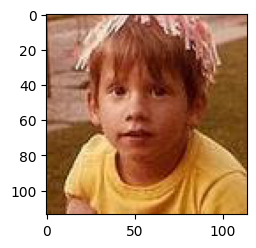

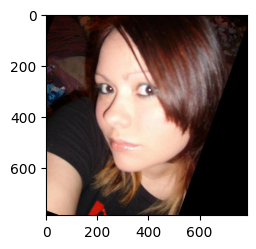

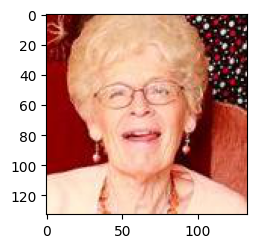

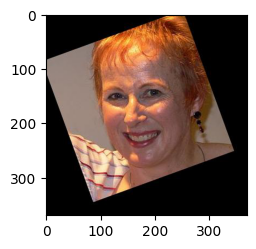

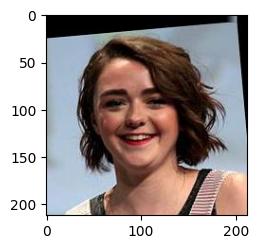

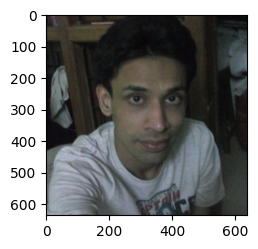

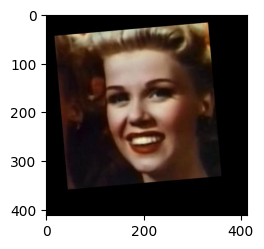

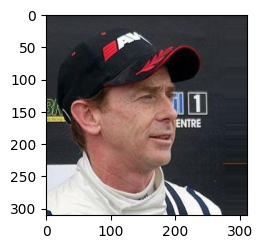

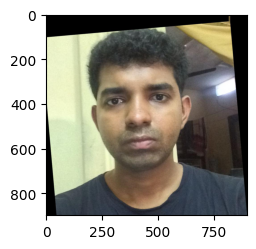

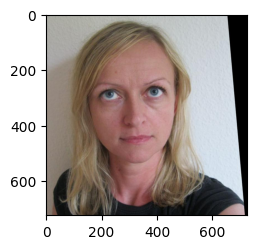

In [4]:
from PIL import Image
for x in range(10):
    image = Image.open(f'/datasets/faces/final_files/00000{x}.jpg')
    array = np.array(image)
    fig = plt.subplots(figsize=(15,15))
    if x < 5:
        plt.subplot(2, 5, x+1)
        plt.imshow(array)
    else:
        plt.subplot(2, 5, x+1)
        plt.imshow(array)

### Conclusiones

* Encontramos un total de 7,591 fotografías.
* La edad máxima de nuestro set es de 100 años mientras que la edad mínima es de 1 año.
* La edad promedio del conjunto de datos ronda los 31 años.


## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [5]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        fill_mode='nearest')

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

In [7]:
def load_test(path):
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        fill_mode='nearest')
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
  
    return test_datagen_flow


In [8]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    backbone=ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
  
    optimizer = Adam(lr=0.0001)
    model.compile(
        loss='mse', optimizer=optimizer, metrics=['mae'])

    return model
   

In [9]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
  
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    
    return model
    

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [15]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


def load_train(path='/datasets/faces/final_files/'):
 
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.25,
      fill_mode='nearest')

  train_datagen_flow = train_datagen.flow_from_dataframe(
      dataframe=pd.read_csv('/datasets/faces/labels.csv'),
      directory='/datasets/faces/final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=16,
      class_mode='raw',
      subset='training',
      seed=12345)
  
  return train_datagen_flow

def load_test(path='/datasets/faces/final_files/'):
    
  test_datagen = ImageDataGenerator(
      validation_split=0.25,
      rescale=1./255,
      fill_mode='nearest')
    
  test_datagen_flow = test_datagen.flow_from_dataframe(
      dataframe=pd.read_csv('/datasets/faces/labels.csv'),
      directory='/datasets/faces/final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224,224),
      batch_size=16,
      class_mode='raw',
      subset='validation',
      seed=12345)
  
  return test_datagen_flow

def create_model(input_shape):

  backbone=ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
 
  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu'))
  
  optimizer = Adam(lr=0.0001)
  model.compile(
      loss='mse', optimizer=optimizer, metrics=['mae'])

  return model

def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=7,
    steps_per_epoch=None,
    validation_steps=None):
    
 
  if steps_per_epoch is None:
    steps_per_epoch = len(train_data)
  if validation_steps is None:
    validation_steps = len(test_data) 
  
  model.fit(
      train_data,
      validation_data=test_data,
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      verbose=2)
    
  return model

"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

Train for 356 steps, validate for 119 steps
Epoch 1/7 356/356 - 46s - loss: 203.2651 - mae: 10.3547 - val_loss: 701.7613 - val_mae: 21.4572

Epoch 2/7 356/356 - 37s - loss: 65.9467 - mae: 6.1770 - val_loss: 131.8959 - val_mae: 8.6972

Epoch 3/7 356/356 - 37s - loss: 37.6964 - mae: 4.7197 - val_loss: 96.2380 - val_mae: 7.3479

Epoch 4/7 356/356 - 37s - loss: 24.9128 - mae: 3.8256 - val_loss: 70.1444 - val_mae: 6.3600

Epoch 5/7 356/356 - 37s - loss: 17.5678 - mae: 3.2607 - val_loss: 69.5958 - val_mae: 6.3473

Epoch 6/7 356/356 - 37s - loss: 14.1168 - mae: 2.8536 - val_loss: 72.4004 - val_mae: 6.5831

Epoch 7/7 356/356 - 37s - loss: 12.0119 - mae: 2.6178 - val_loss: 68.7621 - val_mae: 6.2309

119/119 - 9s - loss: 68.7621 - mae: 6.23

Test MAE: 6.23




## Conclusiones

1. El error absoluto medio fue de 6.2 por lo es una buen modelo